In [1]:
#author: James Chan © 2018
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import st_utils as sut
import trader_utils as tut
import string

from scipy.stats import mode

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from dateutil import parser
from datetime import timedelta, date

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
# initialize date range
start_date = '2018-01-01'
end_date = '2018-8-31'

In [3]:
# grab news.  only need to do this once
keywords = ['tesla'] #these three stocks move largely base on news
news_source = 'wsj.com, bloomberg.com, cnbc.com'
df = sut.get_news(keywords, start_date, end_date, news_source)
df.to_csv('news_dataset.csv')

{'status': 'ok', 'totalResults': 1917, 'articles': []}
total number of articles  1917
downloading page:  1
downloading page:  2
downloading page:  3
downloading page:  4
downloading page:  5
downloading page:  6
downloading page:  7
downloading page:  8
downloading page:  9
downloading page:  10
downloading page:  11
downloading page:  12
downloading page:  13
downloading page:  14
downloading page:  15
downloading page:  16
downloading page:  17
downloading page:  18
downloading page:  19
downloading page:  20
download complete


In [4]:
# get Tesla's prices
dates = pd.date_range(start_date, end_date)
file = 'TSLA.csv'
df_stock = sut.get_data(file, dates)
df_stock.head()

,Adj Close
2018-01-02,320.529999
2018-01-03,317.250000
2018-01-04,314.619995
2018-01-05,316.579987
2018-01-08,336.410004


In [5]:
# calculate return 
df_stock['Return'] = df_stock['Adj Close'].shift(-1)/df_stock['Adj Close'].values-1.0
df_stock.drop(df_stock.index[-1], inplace=True)

In [6]:
df_news = pd.read_csv('news_dataset.csv', index_col=0, encoding="ISO-8859-1")
df_news.head()

,Published,Title,Body,Keyword,Source
0,2018-04-03T13:05:17Z,"Tesla Ends 1Q Making 2,020 Model 3 Sedans per ...","Tesla 1Q deliveries totaled 29,980 vehicles, B...",tesla,Bloomberg
1,2018-07-24T07:48:09Z,Tesla Wants Its Money Back,Elon Musk is asking for donations to save Tesl...,tesla,The Wall Street Journal
2,2018-07-01T22:13:00Z,What Tesla can do to keep the bears at bay dur...,"Buckle up, because Tesla could be in for a bum...",tesla,CNBC
3,2018-05-09T15:00:00Z,Two Florida teenagers killed in Tesla crash,Tesla said it is cooperating with authorities ...,tesla,CNBC
4,2018-05-10T19:00:00Z,NHTSA joins NTSB in looking into fatal Tesla c...,Tesla said it is cooperating with authorities ...,tesla,CNBC


In [7]:
# map published time to close date.  see figure.1
def map_to_close_date(published_date):
    dt = parser.parse(published_date[:-1]) #-1 to ignore the Z, which is GMT.
    dt = dt - timedelta(hours=20) #shift back by 20 hrs.
    return pd.Timestamp(year=dt.year, month=dt.month, day=dt.day)

In [8]:
# map news to close date
df_news['Published'] = df_news['Published'].apply(map_to_close_date)

In [9]:
# combine title and body into single text
df_news['Text'] = df_news['Title'] + ' ' + df_news['Body']

In [10]:
# just keep published, and the combined text
df_news = df_news[['Published','Text']]

In [11]:
# merge news and stock
df_stock['Published'] = df_stock.index
df_merged = pd.merge(df_news, df_stock, how='left', on='Published')
df_merged = df_merged.dropna()
df_merged = df_merged.sort_values(by='Published')
df_merged.head()

,Published,Text,Adj Close,Return
1407,2018-01-02,Stock Fund That Beats 95% of Peers Ignores CEO...,320.529999,-0.010233
1733,2018-01-02,Five Things You Need to Know to Start Your Day...,320.529999,-0.010233
1718,2018-01-02,Car Sales to Top 90 Million Globally for First...,320.529999,-0.010233
409,2018-01-02,"With one simple tweet, Elon Musk shows a maste...",320.529999,-0.010233
1398,2018-01-02,Electric Car Drivers Are Too Smart to Own Elec...,320.529999,-0.010233


In [12]:
def tokenize_news(text):
    if(type(text)==float):
        return []
    lmtzr = WordNetLemmatizer()
    stmr = PorterStemmer()
    translator = str.maketrans('', '', string.punctuation)
    text = (text.translate(translator))
    text = "".join(c for c in text if ord(c)<128) #strip no n ascii characters
    tokens = word_tokenize(text)
    t = []
    minlen =  4
    maxlen = 20 
    for token in tokens:
        if len(token) < minlen or len(token) > maxlen or token.isnumeric() or token in stopwords.words('english'):
            pass
        else:
            token = lmtzr.lemmatize(token)
            token = stmr.stem(token)
            t.append(token)
    return t

In [13]:
df_merged['Text'] = df_merged['Text'].apply(tokenize_news)

In [14]:
df_merged.head()

,Published,Text,Adj Close,Return
1407,2018-01-02,"[stock, fund, that, beat, peer, ignor, talk, r...",320.529999,-0.010233
1733,2018-01-02,"[five, thing, need, know, start, your, caught,...",320.529999,-0.010233
1718,2018-01-02,"[sale, million, global, first, time, global, s...",320.529999,-0.010233
409,2018-01-02,"[with, simpl, tweet, elon, musk, show, master,...",320.529999,-0.010233
1398,2018-01-02,"[electr, driver, smart, electr, car, almost, p...",320.529999,-0.010233


In [15]:
df_merged

,Published,Text,Adj Close,Return
1407,2018-01-02,"[stock, fund, that, beat, peer, ignor, talk, r...",320.529999,-0.010233
1733,2018-01-02,"[five, thing, need, know, start, your, caught,...",320.529999,-0.010233
1718,2018-01-02,"[sale, million, global, first, time, global, s...",320.529999,-0.010233
409,2018-01-02,"[with, simpl, tweet, elon, musk, show, master,...",320.529999,-0.010233
1398,2018-01-02,"[electr, driver, smart, electr, car, almost, p...",320.529999,-0.010233
29,2018-01-03,"[tesla, deliv, model, sedan, total, vehicl, fo...",317.250000,-0.008290
394,2018-01-03,"[tesla, lacklust, model, sale, miss, lower, wa...",317.250000,-0.008290
553,2018-01-03,"[exgoogl, tesla, driverless, czar, partner, wi...",317.250000,-0.008290
22,2018-01-03,"[tesla, model, product, snarl, wall, street, w...",317.250000,-0.008290
42,2018-01-03,"[stock, watch, tesla, maci, walgreen, boot, al...",317.250000,-0.008290


In [16]:
#construct vocabulary and frequency.  frequency is not really needed, just nice to have for understanding the concept.
vocab = {}
frequency = {}
ignore = ['bloomberg', 'journal']
index = 0
for title in df_merged['Text']:
    for word in title:
        if word in ignore:
            continue
        if word not in vocab:
            
            vocab[word] = index
            index += 1
            frequency[word] = 1
        else:
            frequency[word] += 1

In [17]:
#visualize words frequency
for i, freq in enumerate(sorted(frequency.items(), key=lambda x:x[1], reverse=True)):
    if i == 10:
        break
    print(freq)

('tesla', 1094)
('musk', 458)
('elon', 364)
('compani', 254)
('stock', 248)
('model', 240)
('say', 180)
('china', 160)
('share', 159)
('electr', 159)


In [18]:
vocab_len = len(vocab)

In [19]:
in_sd = df_merged['Published'].iloc[0]
in_ed = pd.datetime(2018,6,29)
out_sd = pd.datetime(2018,7,2)
out_ed = df_merged['Published'].iloc[-1]

df_training_data = df_merged[np.logical_and(df_merged['Published'] >= in_sd, df_merged['Published'] <= in_ed)]
df_testing_data = df_merged[np.logical_and(df_merged['Published'] >= out_sd, df_merged['Published'] <= out_ed)]

In [20]:
df_training_data.iloc[:20]

,Published,Text,Adj Close,Return
1407,2018-01-02,"[stock, fund, that, beat, peer, ignor, talk, r...",320.529999,-0.010233
1733,2018-01-02,"[five, thing, need, know, start, your, caught,...",320.529999,-0.010233
1718,2018-01-02,"[sale, million, global, first, time, global, s...",320.529999,-0.010233
409,2018-01-02,"[with, simpl, tweet, elon, musk, show, master,...",320.529999,-0.010233
1398,2018-01-02,"[electr, driver, smart, electr, car, almost, p...",320.529999,-0.010233
29,2018-01-03,"[tesla, deliv, model, sedan, total, vehicl, fo...",317.250000,-0.008290
394,2018-01-03,"[tesla, lacklust, model, sale, miss, lower, wa...",317.250000,-0.008290
553,2018-01-03,"[exgoogl, tesla, driverless, czar, partner, wi...",317.250000,-0.008290
22,2018-01-03,"[tesla, model, product, snarl, wall, street, w...",317.250000,-0.008290
42,2018-01-03,"[stock, watch, tesla, maci, walgreen, boot, al...",317.250000,-0.008290


In [21]:
df_testing_data.iloc[:20]

,Published,Text,Adj Close,Return
1636,2018-07-02,"[glencor, target, corrupt, probeenergi, journa...",335.070007,-0.072254
283,2018-07-02,"[shout, elon, musk, chang, rule, insid, telsa,...",335.070007,-0.072254
1633,2018-07-02,"[progress, dont, hate, trump, even, berni, san...",335.070007,-0.072254
720,2018-07-02,"[german, leader, say, migrat, clash, with, mer...",335.070007,-0.072254
486,2018-07-02,"[tesla, share, close, despit, model, goal, ann...",335.070007,-0.072254
539,2018-07-02,"[tesla, stop, brake, roll, test, push, model, ...",335.070007,-0.072254
540,2018-07-02,"[stock, watch, facebook, tesla, campbel, amazo...",335.070007,-0.072254
1013,2018-07-02,"[tech, ralli, long, cnbc, cnbc, tech, ralli, l...",335.070007,-0.072254
330,2018-07-02,"[tesla, chief, engin, tesla, inc, engin, doug,...",335.070007,-0.072254
114,2018-07-02,"[tesla, engin, leader, doug, field, depart, te...",335.070007,-0.072254


In [22]:
def to_one_hot(text):
    #return one hot vector of shape (vocab_len, 1)
    array = np.zeros((vocab_len, 1))
    for word in text:
        if word in vocab:
            index = vocab[word]
            array[index] = 1
    return array

In [23]:
def get_X(df_text):
    X = np.empty((vocab_len,0))
    for text in df_text:
        array = to_one_hot(text)
        X = np.hstack((X,array))
    X = X.T
    return X

In [24]:
# here is the exciting part. here we are going to create the training data!
train_x = get_X(df_training_data['Text'])
test_x = get_X(df_testing_data['Text'])

In [25]:
# get labels
train_y = df_training_data['Return'].values.copy()
test_y = df_testing_data['Return'].values.copy()

In [26]:
train_y[train_y <= 0] = 0
train_y[train_y > 0] = 1

test_y[test_y <= 0] = 0
test_y[test_y > 0] = 1

In [27]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1100, 4528)
(1100,)
(129, 4528)
(129,)


In [28]:
#train the model
model = Sequential()
model.add(Dense(1, input_dim=train_x.shape[1], activation='relu', kernel_initializer='uniform'))
# model.add(Dense(12, activation='relu', kernel_initializer='uniform'))
# model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
1100/1100 [==============================] - 1s 551us/step - loss: 4.1858 - acc: 0.5245
Epoch 2/50
1100/1100 [==============================] - 0s 130us/step - loss: 1.9872 - acc: 0.5336
Epoch 3/50
1100/1100 [==============================] - 0s 123us/step - loss: 1.1497 - acc: 0.5627
Epoch 4/50
1100/1100 [==============================] - 0s 119us/step - loss: 0.9535 - acc: 0.5945
Epoch 5/50
1100/1100 [==============================] - 0s 124us/step - loss: 0.8575 - acc: 0.6055
Epoch 6/50
1100/1100 [==============================] - 0s 119us/step - loss: 0.7762 - acc: 0.6518
Epoch 7/50
1100/1100 [==============================] - 0s 122us/step - loss: 0.7247 - acc: 0.6773
Epoch 8/50
1100/1100 [==============================] - 0s 125us/step - loss: 0.6940 - acc: 0.7027
Epoch 9/50
1100/1100 [==============================] - 0s 119us/step - loss: 0.6568 - acc: 0.7218
Epoch 10/50
1100/1100 [==============================] - 0s 124us/step - loss: 0.5948 - acc: 0.7436
Epoch 11/

In [29]:
#view weights
weights, biases = model.layers[0].get_weights()
for i, k in enumerate(vocab.keys()):
    if i == 10:
        break
    print(k, weights[i])

stock [-0.00707597]
fund [0.07703205]
that [0.08549499]
beat [0.03028451]
peer [-0.05662004]
ignor [-0.2231586]
talk [-0.05857677]
research [0.03348402]
read [-0.02395565]
brokerag [-0.06776781]


In [30]:
#assess in-sample accuracy
predictions = model.predict_classes(train_x)
predictions = predictions.reshape((predictions.shape[0],))
np.sum(predictions == train_y) / train_y.shape[0]

0.9672727272727273

In [31]:
#assess out-of-sample accuracy
predictions = model.predict_classes(test_x)
predictions = predictions.reshape((predictions.shape[0],))
np.sum(predictions == test_y) / test_y.shape[0]

0.5271317829457365

In [56]:
#generate trades
def generate_trades(df, ticker):
    sd = df['Published'].iloc[0]
    ed = df['Published'].iloc[-1]
    trades = tut.get_prices(ticker, sd, ed)
    trades[:] = 0
    curr_date = sd
    votes = []
    for date, text in zip(df['Published'], df['Text']):
        if date != curr_date:
            trades.loc[curr_date] = mode(votes)[0][0]
            votes = []
            curr_date = date
        text_vector = to_one_hot(text)
        prediction = model.predict_classes(text_vector.T)
        votes.append(prediction[0][0])
    trades = tut.predictions_to_trades(ticker, trades.values, sd, ed, 1, 0)
    return trades

In [42]:
in_trades = generate_trades(df_training_data, 'TSLA')

(125, 1)


In [43]:
starting_cash = 100000
holding_limit = 1000
btr = tut.BackTester(starting_cash, holding_limit)

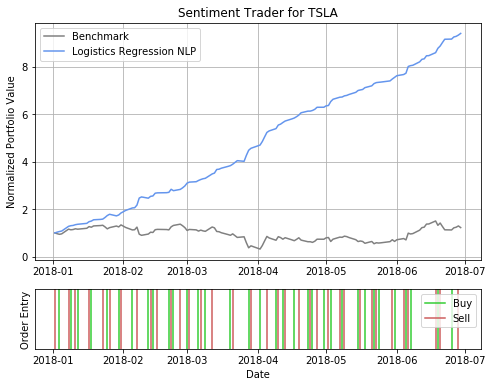

In [44]:
btr.backtest(in_trades, 'Sentiment Trader for TSLA', 'Logistics Regression NLP')

In [49]:
df_testing_data

,Published,Text,Adj Close,Return
1636,2018-07-02,"[glencor, target, corrupt, probeenergi, journa...",335.070007,-0.072254
283,2018-07-02,"[shout, elon, musk, chang, rule, insid, telsa,...",335.070007,-0.072254
1633,2018-07-02,"[progress, dont, hate, trump, even, berni, san...",335.070007,-0.072254
720,2018-07-02,"[german, leader, say, migrat, clash, with, mer...",335.070007,-0.072254
486,2018-07-02,"[tesla, share, close, despit, model, goal, ann...",335.070007,-0.072254
539,2018-07-02,"[tesla, stop, brake, roll, test, push, model, ...",335.070007,-0.072254
540,2018-07-02,"[stock, watch, facebook, tesla, campbel, amazo...",335.070007,-0.072254
1013,2018-07-02,"[tech, ralli, long, cnbc, cnbc, tech, ralli, l...",335.070007,-0.072254
330,2018-07-02,"[tesla, chief, engin, tesla, inc, engin, doug,...",335.070007,-0.072254
114,2018-07-02,"[tesla, engin, leader, doug, field, depart, te...",335.070007,-0.072254


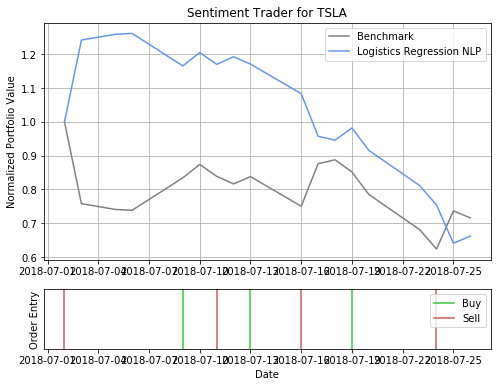

In [57]:
out_trades = generate_trades(df_testing_data, 'TSLA')
btr.backtest(out_trades, 'Sentiment Trader for TSLA', 'Logistics Regression NLP')